In [1]:
from openbb import obb
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import numpy as np
from libs.backtester import Backtester
from backtesting import Strategy

plt.rcParams["figure.figsize"] = (15,7)
plt.style.use("dark_background")
pd.set_option('display.max_columns', None)

from dotenv import dotenv_values

config = dotenv_values(".env") 
obb.account.login(pat=config['OPENBB_PAT'])

import libs.utils

In [2]:
start_date = '1999-01-01'
end_date = '2001-01-01'

In [3]:
QQQ_OBB = obb.equity.price.historical('QQQ', provider='yfinance', start_date=start_date, end_date=end_date)
QQQ = QQQ_OBB.to_dataframe()
QQQ.index = pd.to_datetime(QQQ.index)

QQQ.head()

,open,high,low,close,volume,split_ratio,dividend,capital_gains
date,,,,,,,,
1999-03-10,51.12500,51.156250,50.28125,51.0625,5232000,0.0,0.0,0.0
1999-03-11,51.43750,51.734375,50.31250,51.3125,9688600,0.0,0.0,0.0
1999-03-12,51.12500,51.156250,49.65625,50.0625,8743600,0.0,0.0,0.0
1999-03-15,50.43750,51.562500,49.90625,51.5000,6369000,0.0,0.0,0.0
1999-03-16,51.71875,52.156250,51.15625,51.9375,4905800,0.0,0.0,0.0


In [4]:
QQQ['mean'] = QQQ['close'].rolling(20, 1).mean()
QQQ['std'] = QQQ['close'].rolling(20, 1).std()
QQQ['std_pos1'] = QQQ['mean'] + QQQ['std']
QQQ['std_neg1'] = QQQ['low'].rolling(20, 1).mean() - QQQ['std']

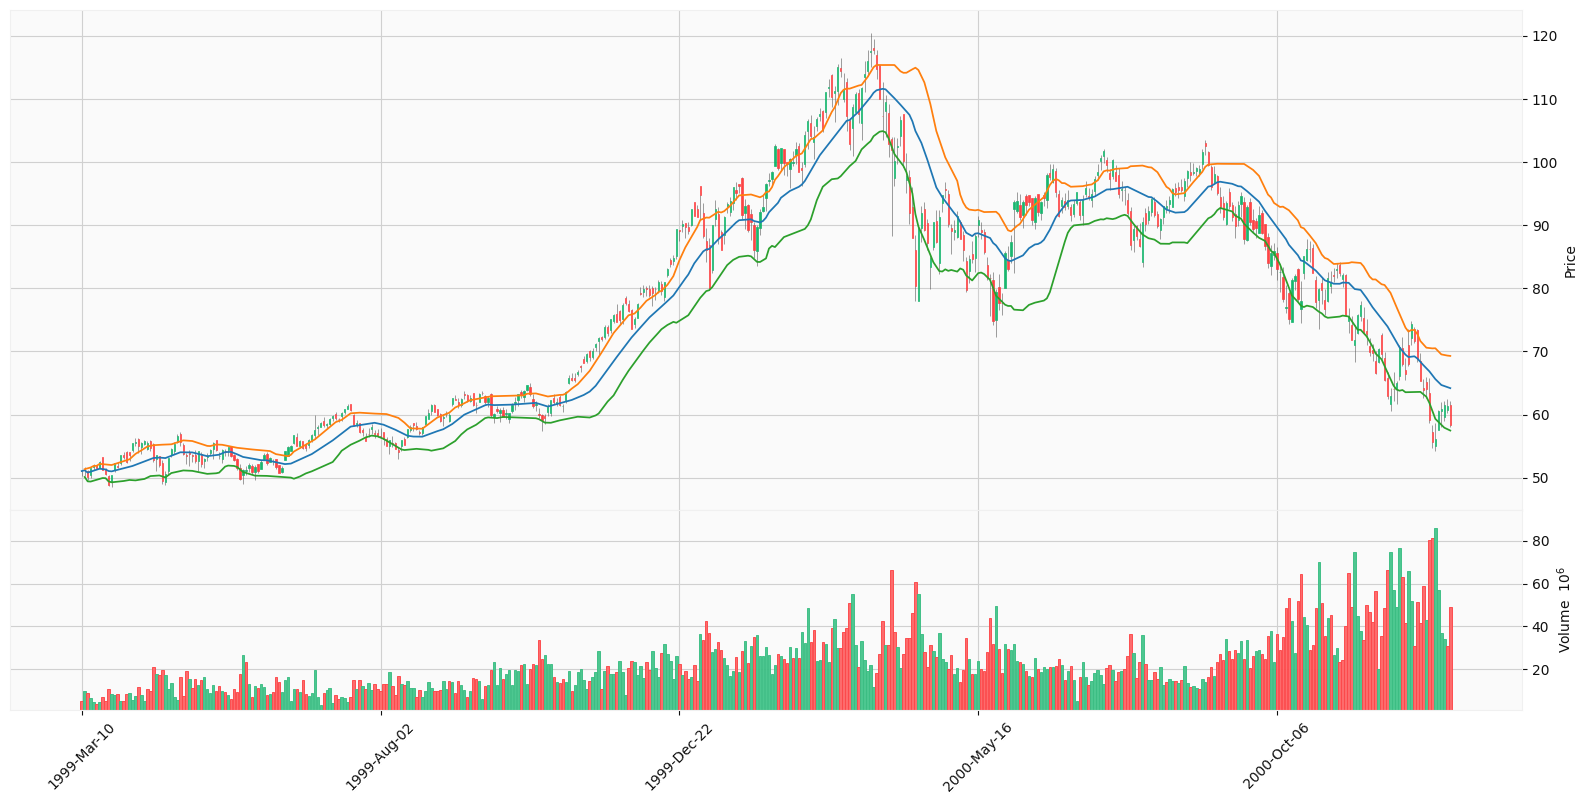

In [5]:
libs.utils.plot_graph(df=QQQ, selected_cols_regex=['mean', 'std_'])

In [6]:
QQQ['close_below_stdneg1'] = (QQQ['close'] <= QQQ['std_neg1'])

In [7]:
QQQ['returns_pct'] = ( QQQ['close'] / QQQ['close'].shift(1) ) - 1
QQQ['returns_std'] = QQQ['close'].diff() / QQQ['std']
QQQ['returns_std_mean'] = QQQ['returns_std'].rolling(10).mean()
QQQ['neg_returns_std_mean'] = QQQ['returns_std_mean'].apply(lambda x: True if x < -0.1 else False)

In [8]:
QQQ = QQQ.dropna()
QQQ

,open,high,low,close,volume,split_ratio,dividend,capital_gains,mean,std,std_pos1,std_neg1,close_below_stdneg1,returns_pct,returns_std,returns_std_mean,neg_returns_std_mean
date,,,,,,,,,,,,,,,,,
1999-03-24,49.25000,50.500000,48.500000,50.46875,8447000,0.0,0.0,0.0,51.008523,1.007306,52.015829,49.275364,False,0.033931,1.644237,0.031702,False
1999-03-25,51.25000,52.312500,50.914062,52.31250,8133800,0.0,0.0,0.0,51.117188,1.031562,52.148750,49.303724,False,0.036533,1.787338,0.069015,False
1999-03-26,51.87500,52.468750,51.531250,51.75000,8256200,0.0,0.0,0.0,51.165865,1.003119,52.168984,49.424165,False,-0.010753,-0.560751,0.201922,False
1999-03-29,52.37500,53.656250,52.062500,53.62500,5113800,0.0,0.0,0.0,51.341518,1.166532,52.508050,49.377553,False,0.036232,1.607328,0.138109,False
1999-03-30,53.56250,54.000000,53.031250,53.25000,4940600,0.0,0.0,0.0,51.468750,1.227362,52.696112,49.482534,False,-0.006993,-0.305533,0.044995,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-22,57.62500,60.750000,57.500000,60.50000,57240000,0.0,0.0,0.0,65.128125,4.875568,70.003693,58.800213,False,0.079153,0.910150,-0.243371,True
2000-12-26,60.59375,61.921875,58.000000,60.87500,37082800,0.0,0.0,0.0,64.693750,4.846615,69.540365,58.291666,False,0.006198,0.077374,-0.388733,True
2000-12-27,59.68750,62.187500,58.937500,61.56250,33955500,0.0,0.0,0.0,64.499219,4.892395,69.391614,57.927136,False,0.011294,0.140524,-0.309287,True


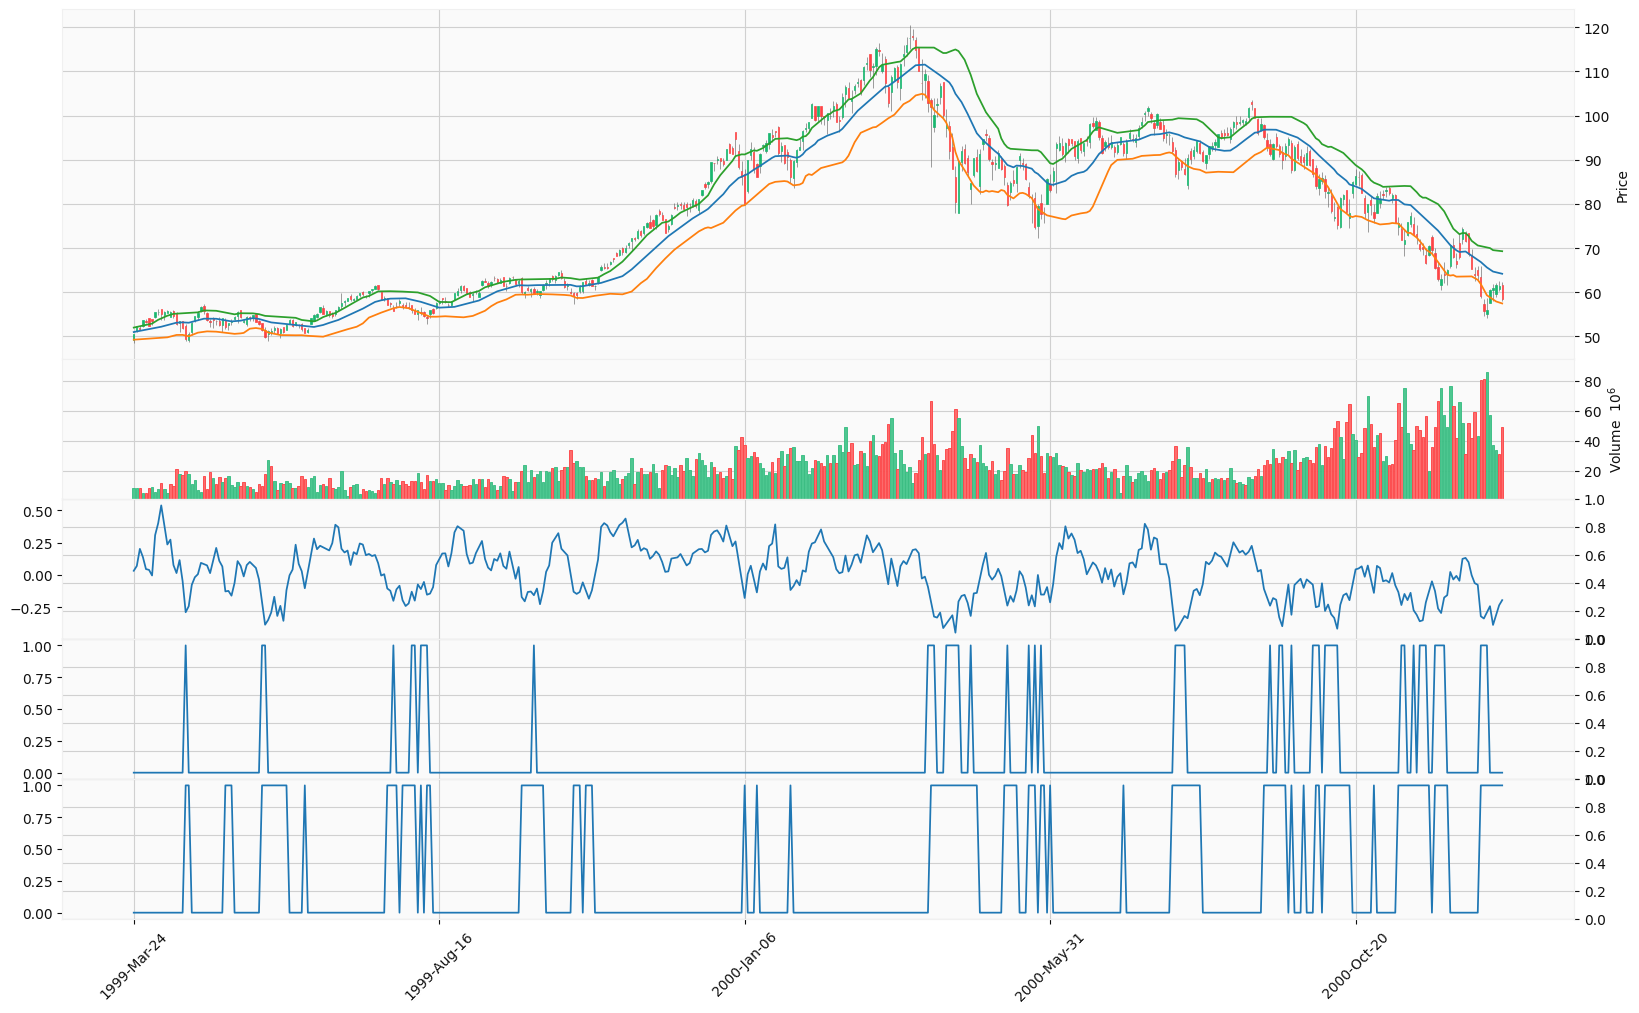

In [9]:
libs.utils.plot_graph(df=QQQ, selected_cols_regex=['mean', 'std_'], panel_cols_regex=['neg_returns_std_mean', 'close_below_stdneg1', 'returns_std_mean'])

In [10]:
QQQ['subsignal'] = QQQ['neg_returns_std_mean'] & QQQ['close_below_stdneg1']

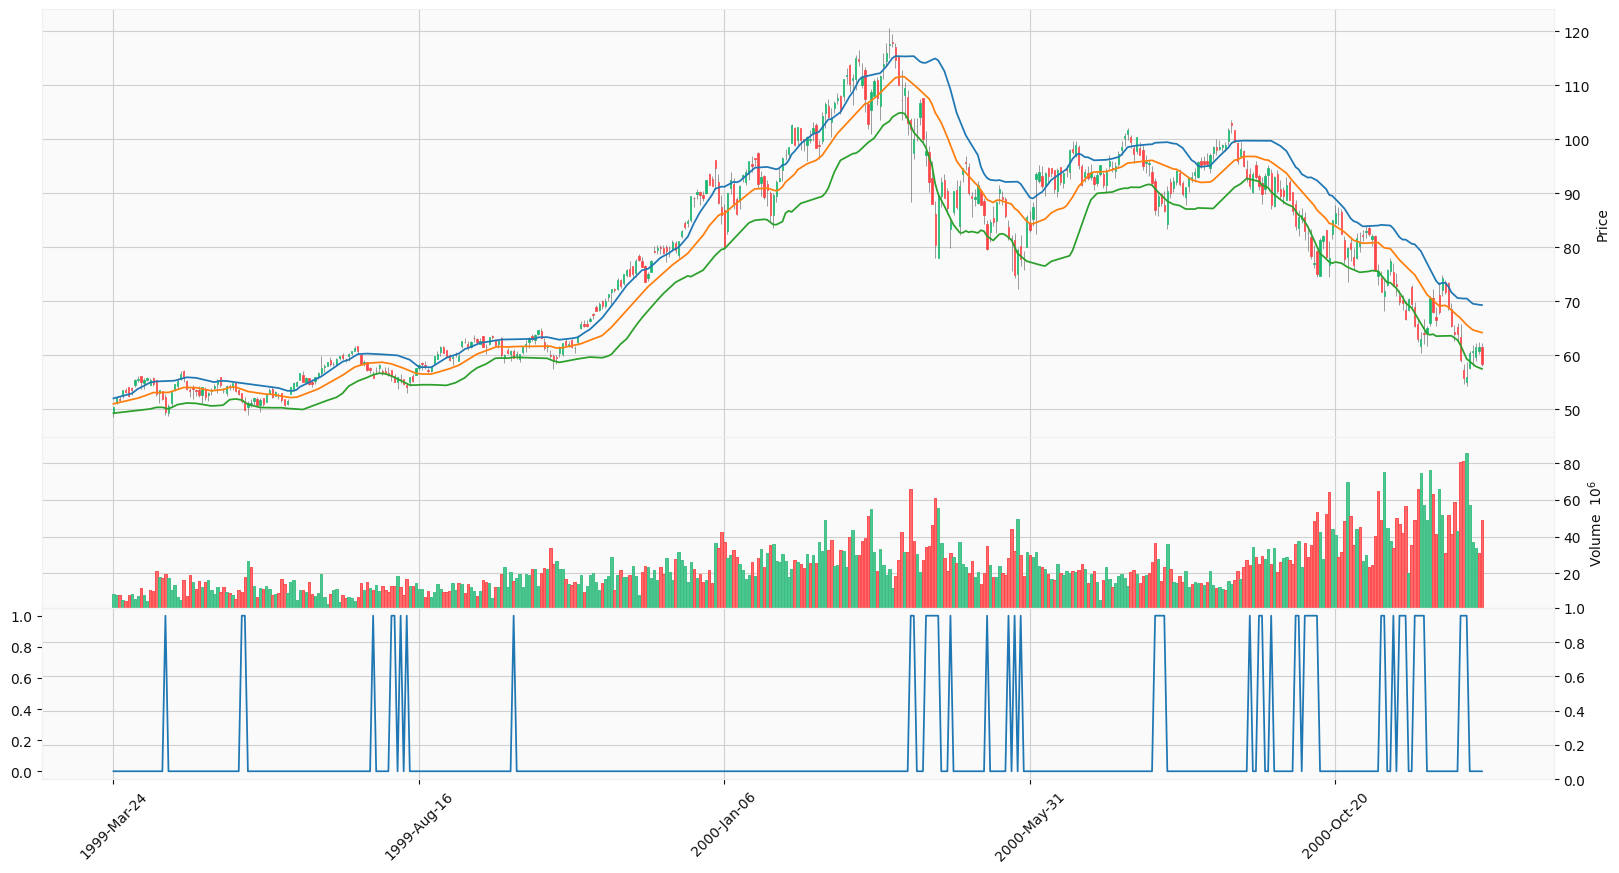

In [11]:
libs.utils.plot_graph(df=QQQ, selected_cols_regex=['mean', 'std_'], panel_cols_regex=['subsignal'])

In [12]:
def compute_gradient(values):
    x = np.arange( len(values) )
    y = values
    return np.gradient(y, x)[-1]

QQQ['gradient_std_neg1'] = QQQ['std_neg1'].rolling(3).apply(compute_gradient, raw=True).rolling(3).mean().apply(lambda x: x < -0.5)


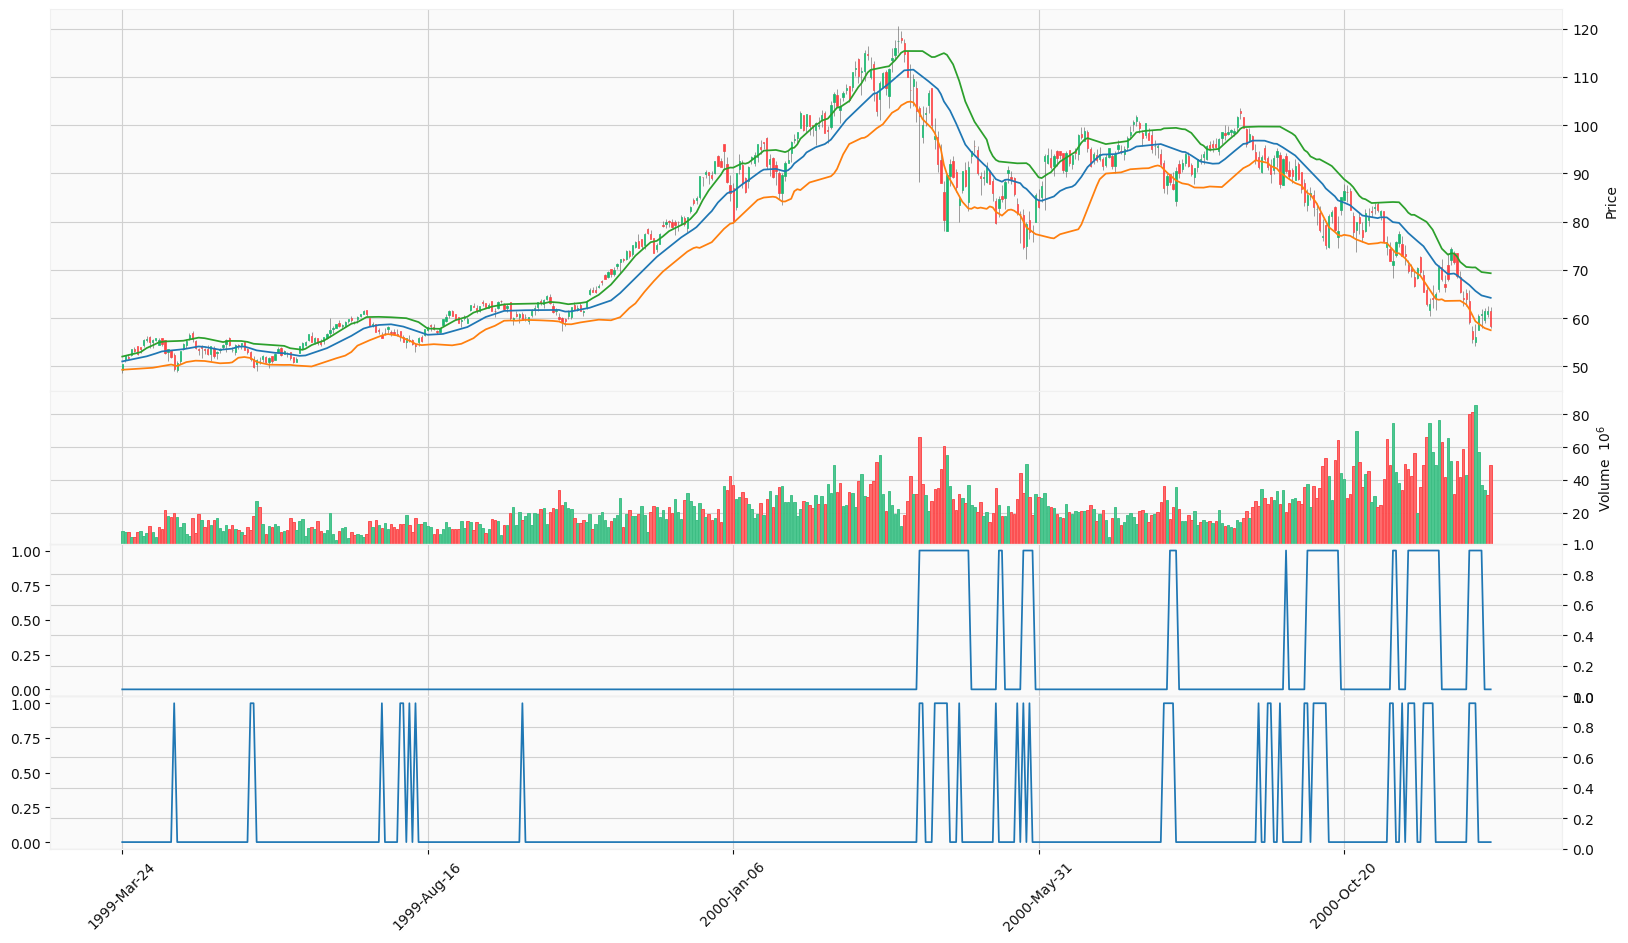

In [13]:
libs.utils.plot_graph(df=QQQ, selected_cols_regex=['mean', 'std_'], panel_cols_regex=['subsignal', 'gradient_std_neg1'])

In [14]:
QQQ['signal'] = ( QQQ['subsignal'] == True ) & (QQQ['subsignal'] != QQQ['gradient_std_neg1']) & (QQQ['gradient_std_neg1'] != True)

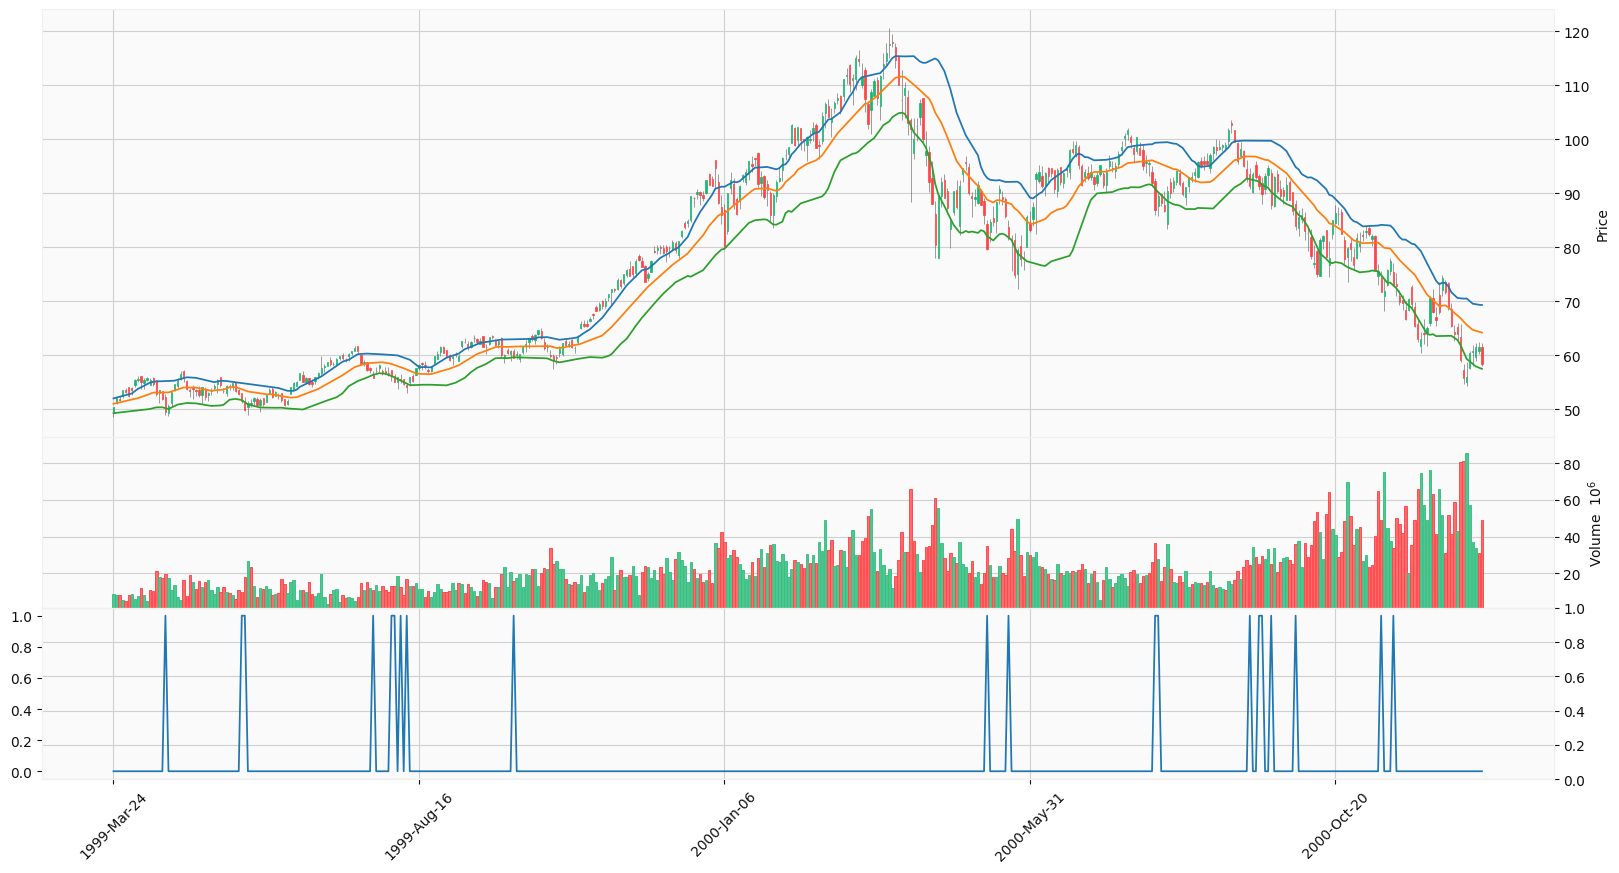

In [15]:
libs.utils.plot_graph(df=QQQ, selected_cols_regex=['mean', 'std_'], panel_cols_regex=['signal'])

In [16]:
trates = obb.fixedincome.government.treasury_rates(start_date=start_date, end_date=end_date, provider='federal_reserve').to_dataframe()
trates.head()

,month_3,month_6,year_1,year_2,year_3,year_5,year_7,year_10,year_20,year_30
date,,,,,,,,,,
1999-01-04,0.0449,0.0457,0.0458,0.0458,0.0457,0.0457,0.0475,0.0469,0.0542,0.0515
1999-01-05,0.0448,0.0457,0.0456,0.0464,0.0464,0.0462,0.0480,0.0474,0.0548,0.0521
1999-01-06,0.0447,0.0455,0.0453,0.0462,0.0462,0.0461,0.0476,0.0473,0.0542,0.0517
1999-01-07,0.0444,0.0449,0.0451,0.0463,0.0463,0.0462,0.0482,0.0477,0.0548,0.0523
1999-01-08,0.0448,0.0453,0.0457,0.0471,0.0471,0.0472,0.0492,0.0486,0.0557,0.0526


<Axes: xlabel='date'>

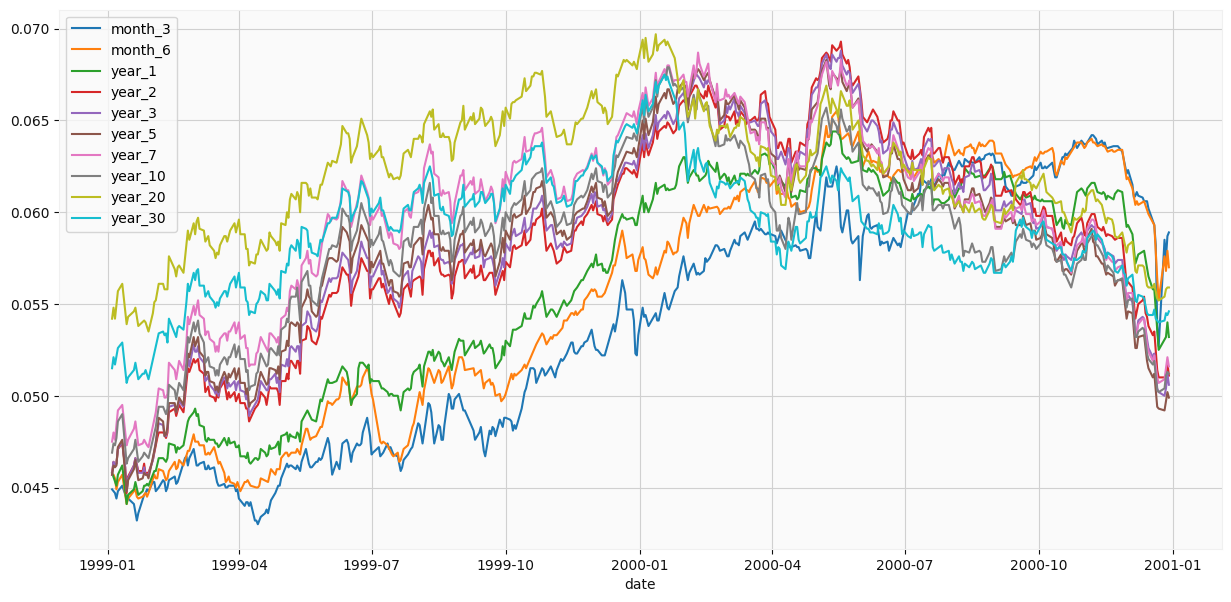

In [17]:
trates.plot(figsize=(15,7))

In [18]:
len(trates)

502

<Axes: >

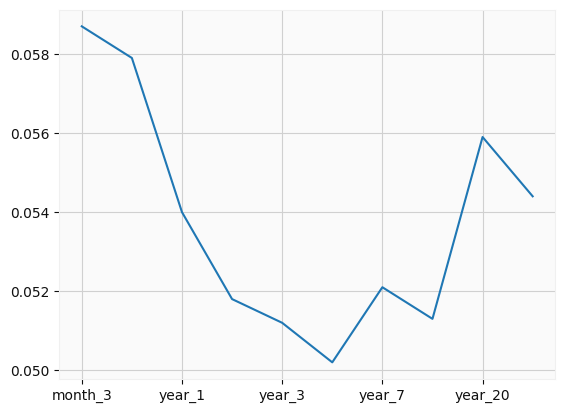

In [19]:
trates.iloc[500].plot()

In [20]:
SPY_OBB = obb.equity.price.historical('SPY', provider='yfinance', start_date=start_date, end_date=end_date)
SPY = SPY_OBB.to_dataframe()
SPY.head()

,open,high,low,close,volume,split_ratio,dividend,capital_gains
date,,,,,,,,
1999-01-04,123.3750,125.21875,121.71875,123.03125,9450400,0.0,0.0,0.0
1999-01-05,122.9375,124.87500,122.93750,124.43750,8031000,0.0,0.0,0.0
1999-01-06,125.8125,127.75000,125.75000,127.43750,7737700,0.0,0.0,0.0
1999-01-07,126.3750,127.21875,125.78125,126.81250,5504900,0.0,0.0,0.0
1999-01-08,128.1875,128.50000,125.96875,127.75000,6224400,0.0,0.0,0.0


In [21]:
def _standardize_ffill(df, column='Adj Close'):
    standardized_df = ( df[column] - df[column].mean() ) / df[column].std()
    standardized_df.fillna(method='ffill', inplace=True)
    return standardized_df

corrdf = pd.DataFrame({ 'SPY_close': SPY['close'], 'QQQ_close': QQQ_OBB.to_dataframe()['close'] }).dropna()
corrdf['SPY_close_norm'] = _standardize_ffill(corrdf, 'SPY_close')
corrdf['QQQ_close_norm'] = _standardize_ffill(corrdf, 'QQQ_close')

corrdf['rcorr'] = corrdf['SPY_close'].rolling(window=30).corr(corrdf['QQQ_close'])

In [22]:
corrdf.to_csv('../data/QQQ_SPY_corr_1999_2000.csv')

In [23]:
corrdf[corrdf.index > date(2000,5,1) ]

,SPY_close,QQQ_close,SPY_close_norm,QQQ_close_norm,rcorr
date,,,,,
2000-05-02,144.125000,90.1250,0.731005,0.719090,0.859934
2000-05-03,140.750000,89.1250,0.226759,0.664687,0.865649
2000-05-04,141.812500,89.3125,0.385503,0.674888,0.872874
2000-05-05,143.531250,91.4375,0.642295,0.790493,0.866789
2000-05-08,142.453125,87.8750,0.481216,0.596685,0.857468
...,...,...,...,...,...
2000-12-22,130.937500,60.5000,-1.239289,-0.892579,0.958249
2000-12-26,132.343750,60.8750,-1.029186,-0.872178,0.952913
2000-12-27,133.312500,61.5625,-0.884449,-0.834776,0.947753


<Axes: xlabel='date'>

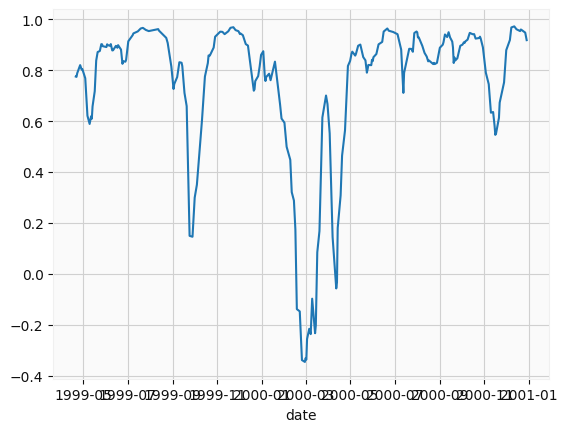

In [24]:
corrdf['rcorr'].plot()

In [45]:
tratesdf = pd.read_csv('../data/trates_1999_2001.csv')
tratesdf.set_index(keys='date', inplace=True)
tratesdf.index = pd.to_datetime(tratesdf.index)
tratesdf.tail()

,month_3,month_6,year_1,year_2,year_3,year_5,year_7,year_10,year_20,year_30,slope,intercept,rss,PC1,PC2
date,,,,,,,,,,,,,,,
2000-12-22,0.0527,0.0552,0.0525,0.0510,0.0502,0.0493,0.0507,0.0502,0.0552,0.0540,-0.000010,0.052144,0.000042,0.372365,0.404248
2000-12-26,0.0585,0.0576,0.0531,0.0510,0.0500,0.0492,0.0509,0.0504,0.0554,0.0541,-0.000422,0.054918,0.000082,1.405181,2.597153
2000-12-27,0.0575,0.0568,0.0532,0.0510,0.0504,0.0499,0.0517,0.0511,0.0558,0.0545,-0.000260,0.054360,0.000065,1.034433,1.637694
2000-12-28,0.0587,0.0579,0.0540,0.0518,0.0512,0.0502,0.0521,0.0513,0.0559,0.0544,-0.000402,0.055558,0.000065,1.276604,1.629408
2000-12-29,0.0589,0.0570,0.0532,0.0511,0.0506,0.0499,0.0516,0.0512,0.0559,0.0546,-0.000337,0.054916,0.000075,1.260512,2.210692


In [39]:
QQQ.tail()

,open,high,low,close,volume,split_ratio,dividend,capital_gains,mean,std,std_pos1,std_neg1,close_below_stdneg1,returns_pct,returns_std,returns_std_mean,neg_returns_std_mean,subsignal,gradient_std_neg1,signal,corr_SPY
date,,,,,,,,,,,,,,,,,,,,,
2000-12-22,57.62500,60.750000,57.5000,60.5000,57240000,0.0,0.0,0.0,65.128125,4.875568,70.003693,58.800213,False,0.079153,0.910150,-0.243371,True,False,True,False,0.958249
2000-12-26,60.59375,61.921875,58.0000,60.8750,37082800,0.0,0.0,0.0,64.693750,4.846615,69.540365,58.291666,False,0.006198,0.077374,-0.388733,True,False,True,False,0.952913
2000-12-27,59.68750,62.187500,58.9375,61.5625,33955500,0.0,0.0,0.0,64.499219,4.892395,69.391614,57.927136,False,0.011294,0.140524,-0.309287,True,False,False,False,0.947753
2000-12-28,60.78125,62.484375,60.2500,61.4375,30996900,0.0,0.0,0.0,64.424219,4.928957,69.353176,57.778074,False,-0.002030,-0.025360,-0.236046,True,False,False,False,0.930550
2000-12-29,61.56250,62.234375,58.0000,58.3750,49191000,0.0,0.0,0.0,64.193750,5.104463,69.298213,57.477568,False,-0.049847,-0.599965,-0.196284,True,False,False,False,0.918160


In [49]:
QQQ = pd.merge(QQQ, tratesdf, left_index=True, right_index=True, how='inner')

In [53]:
QQQ

,open,high,low,close,volume,split_ratio,dividend,capital_gains,mean,std,std_pos1,std_neg1,close_below_stdneg1,returns_pct,returns_std,returns_std_mean,neg_returns_std_mean,subsignal,gradient_std_neg1,signal,corr_SPY,month_3,month_6,year_1,year_2,year_3,year_5,year_7,year_10,year_20,year_30,slope,intercept,rss,PC1,PC2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-03-24,49.25000,50.500000,48.500000,50.46875,8447000,0.0,0.0,0.0,51.008523,1.007306,52.015829,49.275364,False,0.033931,1.644237,0.031702,False,False,False,False,NaN,0.0450,0.0454,0.0473,0.0498,0.0504,0.0507,0.0530,0.0517,0.0584,0.0554,0.001312,0.044805,0.000019,-1.681566,-0.492036
1999-03-25,51.25000,52.312500,50.914062,52.31250,8133800,0.0,0.0,0.0,51.117188,1.031562,52.148750,49.303724,False,0.036533,1.787338,0.069015,False,False,False,False,NaN,0.0451,0.0456,0.0477,0.0502,0.0507,0.0512,0.0535,0.0521,0.0588,0.0559,0.001345,0.045025,0.000019,-1.688586,-0.488252
1999-03-26,51.87500,52.468750,51.531250,51.75000,8256200,0.0,0.0,0.0,51.165865,1.003119,52.168984,49.424165,False,-0.010753,-0.560751,0.201922,False,False,False,False,NaN,0.0451,0.0453,0.0474,0.0499,0.0505,0.0510,0.0535,0.0521,0.0590,0.0561,0.001392,0.044725,0.000019,-1.748980,-0.430074
1999-03-29,52.37500,53.656250,52.062500,53.62500,5113800,0.0,0.0,0.0,51.341518,1.166532,52.508050,49.377553,False,0.036232,1.607328,0.138109,False,False,False,False,NaN,0.0451,0.0452,0.0475,0.0502,0.0508,0.0515,0.0540,0.0528,0.0594,0.0565,0.001458,0.044738,0.000018,-1.811804,-0.461938
1999-03-30,53.56250,54.000000,53.031250,53.25000,4940600,0.0,0.0,0.0,51.468750,1.227362,52.696112,49.482534,False,-0.006993,-0.305533,0.044995,False,False,False,False,NaN,0.0448,0.0450,0.0472,0.0497,0.0503,0.0509,0.0534,0.0521,0.0589,0.0559,0.001415,0.044455,0.000019,-1.796930,-0.437704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-22,57.62500,60.750000,57.500000,60.50000,57240000,0.0,0.0,0.0,65.128125,4.875568,70.003693,58.800213,False,0.079153,0.910150,-0.243371,True,False,True,False,0.958249,0.0527,0.0552,0.0525,0.0510,0.0502,0.0493,0.0507,0.0502,0.0552,0.0540,-0.000010,0.052144,0.000042,0.372365,0.404248
2000-12-26,60.59375,61.921875,58.000000,60.87500,37082800,0.0,0.0,0.0,64.693750,4.846615,69.540365,58.291666,False,0.006198,0.077374,-0.388733,True,False,True,False,0.952913,0.0585,0.0576,0.0531,0.0510,0.0500,0.0492,0.0509,0.0504,0.0554,0.0541,-0.000422,0.054918,0.000082,1.405181,2.597153
2000-12-27,59.68750,62.187500,58.937500,61.56250,33955500,0.0,0.0,0.0,64.499219,4.892395,69.391614,57.927136,False,0.011294,0.140524,-0.309287,True,False,False,False,0.947753,0.0575,0.0568,0.0532,0.0510,0.0504,0.0499,0.0517,0.0511,0.0558,0.0545,-0.000260,0.054360,0.000065,1.034433,1.637694


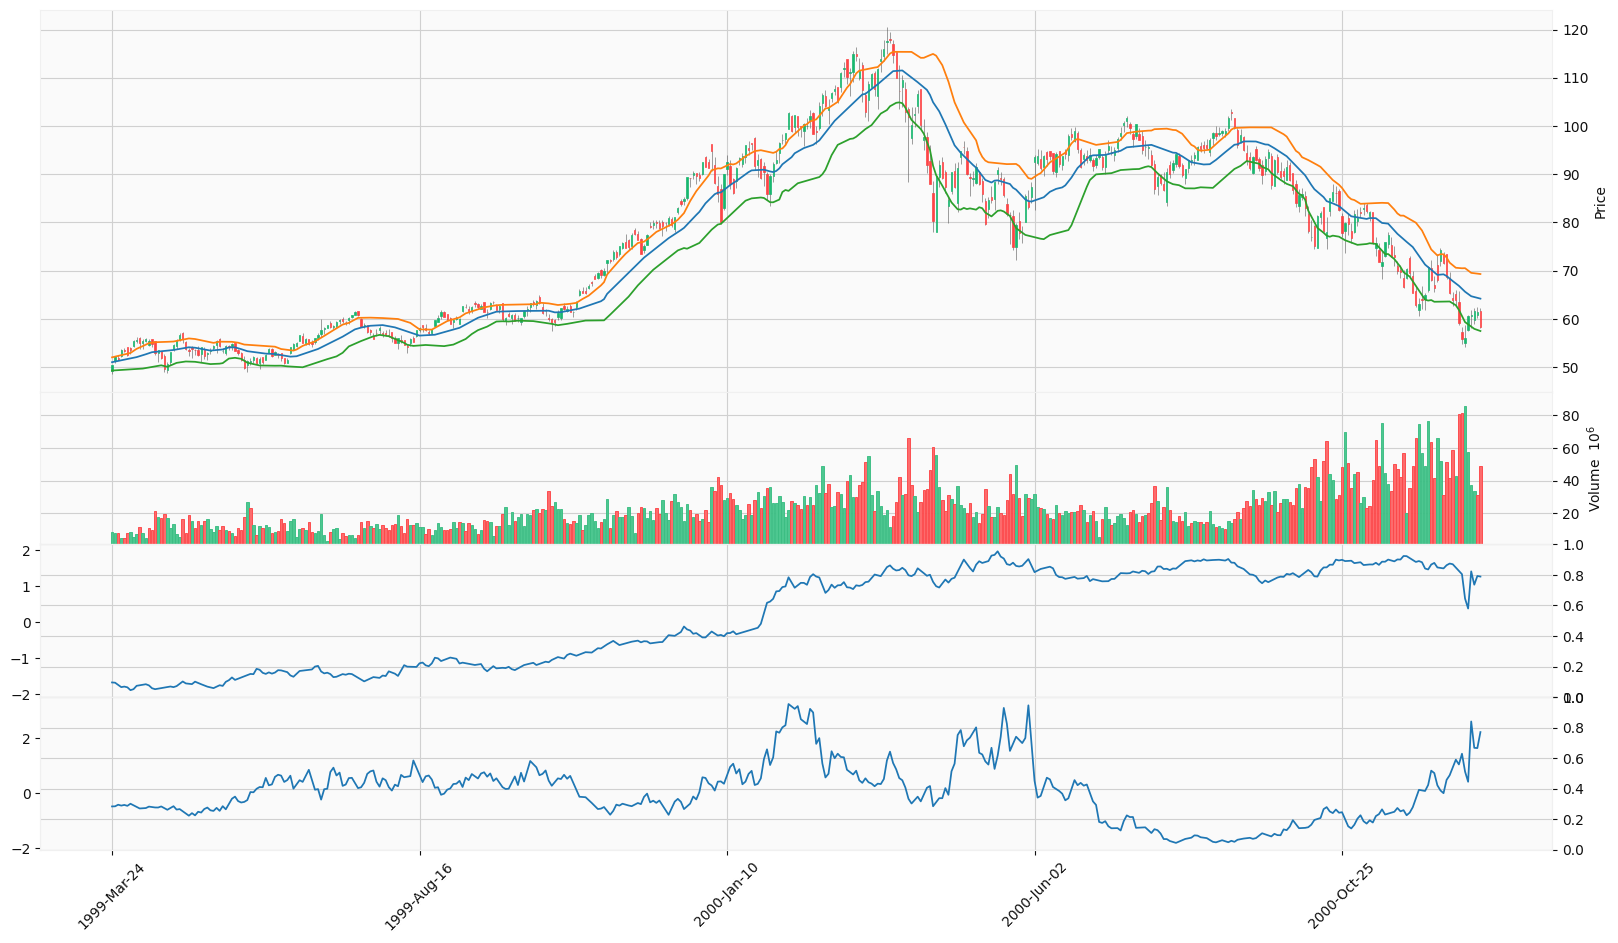

In [51]:
libs.utils.plot_graph(df=QQQ, selected_cols_regex=['mean', 'std_'], panel_cols_regex=['PC1', 'PC2'])

In [27]:
VIX_OBB = obb.equity.price.historical('^VIX', provider='yfinance', start_date=start_date, end_date=end_date)
VIX = VIX_OBB.to_dataframe()
VIX.index = pd.to_datetime(VIX.index)
VIX.head()

,open,high,low,close,volume,split_ratio,dividend
date,,,,,,,
1999-01-04,25.379999,26.959999,24.740000,26.170000,0,0.0,0.0
1999-01-05,25.920000,25.980000,24.360001,24.459999,0,0.0,0.0
1999-01-06,23.360001,23.379999,22.680000,23.340000,0,0.0,0.0
1999-01-07,24.420000,24.900000,24.040001,24.370001,0,0.0,0.0
1999-01-08,22.950001,24.080000,22.809999,23.280001,0,0.0,0.0


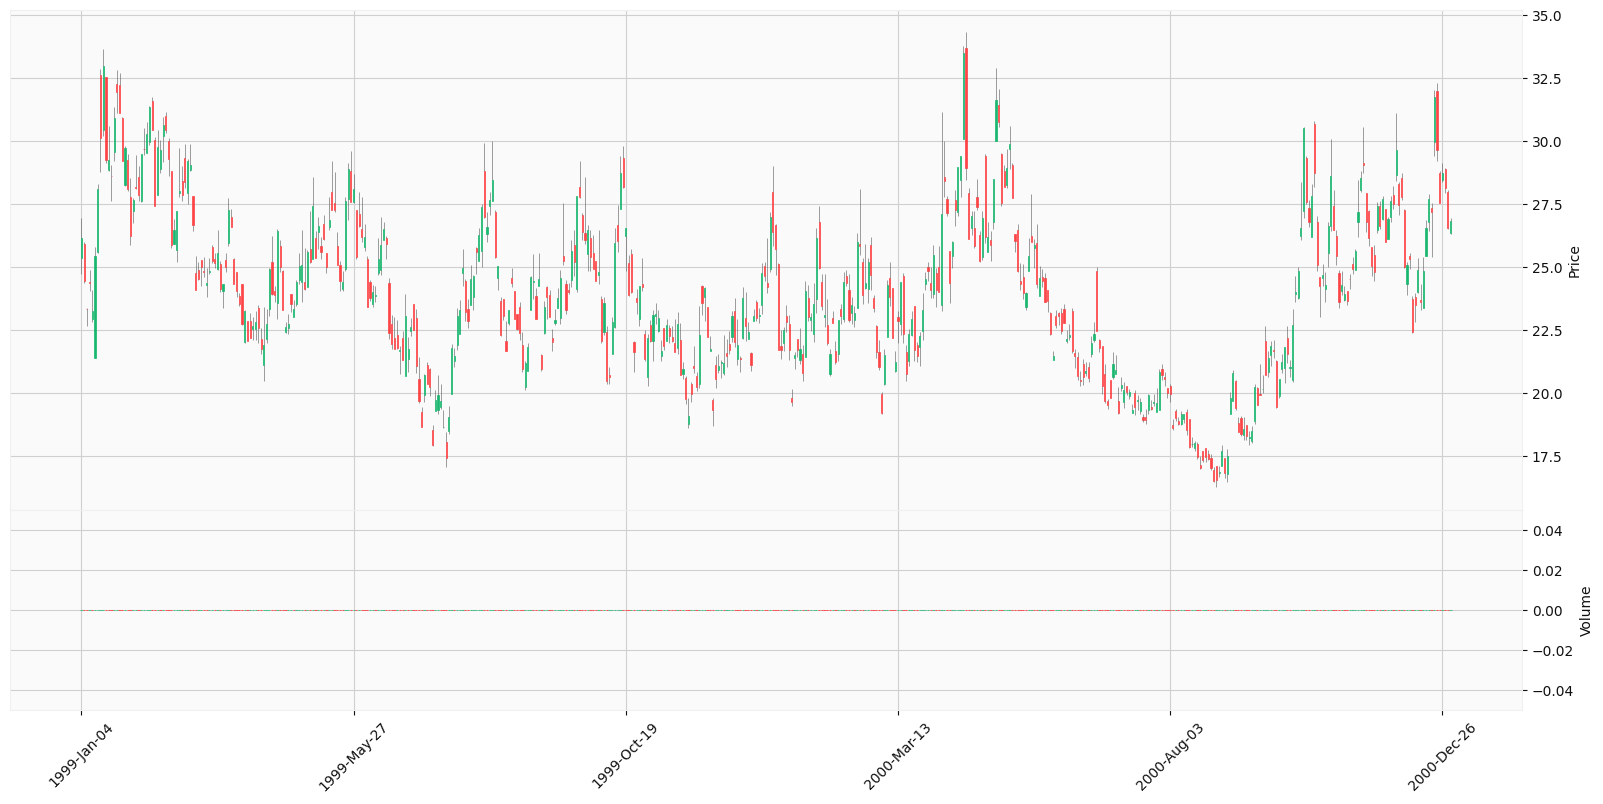

In [28]:
libs.utils.plot_graph(df=VIX)

In [29]:
# def extract(df, column):
#     return df[column]

# class Alpha1(Strategy):
#     NAME = 'alpha 1'
    
#     def init(self):
#         super().init()
        
#     def next(self):
#         super().next()
#         signal = self.data.df['signal'].iloc[-1]
#         close = self.data.Close[-1]
#         if signal:
#             self.buy(size=0.1)
        
        
                
# bt = Backtester(strategy=Alpha1, data=QQQ, capital=100_000, commission=0.00)
# bt.run()